# Support Vector Machines

In [1]:
#!pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,make_scorer,make_scorer, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from gensim.models.doc2vec import TaggedDocument
import os
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
reviews_df = pd.read_csv("reviews_preproc.csv")
reviews_df = reviews_df[["Texto Preprocesado","Valoración"]]
reviews_df = reviews_df.rename(columns={"Texto Preprocesado": "Texto"})
#reviews_df = reviews_df.sample(n = 50000) #Muestra!
reviews_df

,Texto,Valoración
0,excel menu del qualiti ingredi home cook good ...,5
1,realli enjoy food atmospher realli appreci pab...,5
2,amaz tapa skirt sierra nevada,5
3,way alberta make ideal stopov food fine order ...,3
4,staff littl desir work especi guy monday noon ...,1
...,...,...
383367,went review restaur seem good choic correct st...,2
383368,one return place happi spectacular delici,5
383369,excel lunch menu homemad qualiti food kind ser...,5
383370,good music good atmospher good view comfort,5


In [4]:
#Asignamos la polaridad en función de la valoración númerica
reviews_df['Polaridad'] = reviews_df['Valoración'].apply(lambda c: 'Positivo' if c > 3  else('Negativo' if c < 3 else 'Neutro'))
reviews_df

,Texto,Valoración,Polaridad
0,excel menu del qualiti ingredi home cook good ...,5,Positivo
1,realli enjoy food atmospher realli appreci pab...,5,Positivo
2,amaz tapa skirt sierra nevada,5,Positivo
3,way alberta make ideal stopov food fine order ...,3,Neutro
4,staff littl desir work especi guy monday noon ...,1,Negativo
...,...,...,...
383367,went review restaur seem good choic correct st...,2,Negativo
383368,one return place happi spectacular delici,5,Positivo
383369,excel lunch menu homemad qualiti food kind ser...,5,Positivo
383370,good music good atmospher good view comfort,5,Positivo


In [5]:
#Tomamos la polaridad negativa y positiva
reviews_df = reviews_df[(reviews_df['Polaridad'] =='Positivo') | 
          (reviews_df['Polaridad'] == 'Negativo')] 

In [6]:
#Tomamos la muestra para nuestra experimentación (50000)
reviews_positivo_df = reviews_df[reviews_df['Polaridad'] == "Positivo"]
reviews_positivo_df = reviews_positivo_df.dropna()
reviews_positivo_df = reviews_positivo_df.sample(n = 25000)

reviews_negativo_df = reviews_df[reviews_df['Polaridad'] == "Negativo"]
reviews_negativo_df = reviews_negativo_df.dropna()
reviews_negativo_df = reviews_negativo_df.sample(n = 25000)

reviews_df = pd.concat([reviews_positivo_df,reviews_negativo_df])
reviews_df

,Texto,Valoración,Polaridad
118428,amaz food whole roast chicken must tri place g...,5,Positivo
188423,good qualiti price good good clean everyth ord...,5,Positivo
257594,great littl home restaur went lunch reserv rec...,5,Positivo
56915,good fresh food real nice staff,5,Positivo
220584,nice find love famili busi lousi restaur surpr...,4,Positivo
...,...,...,...
38804,empanada chorizo argentin favourit found bland...,2,Negativo
28466,fatal made order tell would take half hour hou...,1,Negativo
302846,eaten time first time good experi fair price q...,2,Negativo
376521,gone breakfast seem like nice terrac surpris s...,1,Negativo


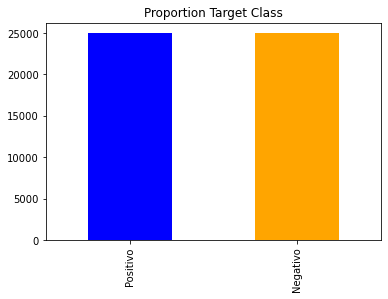

In [7]:
count_class=pd.value_counts(reviews_df["Polaridad"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [8]:
print('Positivo', round(reviews_df['Polaridad'].value_counts()['Positivo']/len(reviews_df) * 100), '%')
print('Negativo', round(reviews_df['Polaridad'].value_counts()['Negativo']/len(reviews_df) * 100), '%')

Positivo 50 %
Negativo 50 %


In [9]:
#Trabajamos con datos numericos (1=Positivo, 0=Negativo)
reviews_df['Texto'] = reviews_df['Texto'].astype(str)
reviews_df['Polaridad'] = reviews_df['Polaridad'].replace(['Positivo', 'Negativo'], [1, 0]) #!!!!!!
reviews_df

,Texto,Valoración,Polaridad
118428,amaz food whole roast chicken must tri place g...,5,1
188423,good qualiti price good good clean everyth ord...,5,1
257594,great littl home restaur went lunch reserv rec...,5,1
56915,good fresh food real nice staff,5,1
220584,nice find love famili busi lousi restaur surpr...,4,1
...,...,...,...
38804,empanada chorizo argentin favourit found bland...,2,0
28466,fatal made order tell would take half hour hou...,1,0
302846,eaten time first time good experi fair price q...,2,0
376521,gone breakfast seem like nice terrac surpris s...,1,0


In [10]:
main_text = reviews_df['Texto']
target = reviews_df['Polaridad']

print(len(main_text))
print(len(target))

50000
50000


In [12]:
#Etiquetamos cada comentario tokenizado con un ID único
def add_label(review):
    output = []
    for i, s in zip(review.index, review):
        output.append(TaggedDocument(s, ["review_" + str(i)]))
    return output

In [13]:
labeled_reviews = add_label(main_text)

In [14]:
#Vectorizamos con Doc2Vec para definir el modelo
from gensim.models import Doc2Vec

d2v_model = Doc2Vec(vector_size=200)
d2v_model.build_vocab([i for i in tqdm(labeled_reviews)])
d2v_model.train(labeled_reviews, total_examples=len(reviews_df['Texto']),epochs=10)
# Crea los vectores de tweets
docvec_arrays = np.zeros((len(reviews_df['Texto']), 200))
for i in range(len(reviews_df)):
    docvec_arrays[i,:] = d2v_model.docvecs[i].reshape((1,200))
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape
# Etiqueta todos los tweets
labeled_reviews = add_label(reviews_df['Texto'])

100%|██████████| 50000/50000 [00:00<00:00, 2500240.83it/s]
C:\Users\curri\AppData\Local\Temp/ipykernel_11068/1099985600.py:9: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  docvec_arrays[i,:] = d2v_model.docvecs[i].reshape((1,200))


In [15]:
docvec_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.008,0.027,-0.003,0.020,0.070,0.014,-0.037,-0.045,-0.034,-0.004,...,0.008,0.029,-0.002,0.074,-0.017,0.026,-0.020,0.025,0.009,0.022
1,-0.035,0.010,0.030,-0.031,0.108,0.010,-0.040,-0.027,0.020,-0.023,...,-0.013,0.018,-0.028,0.044,-0.002,-0.000,0.027,0.020,-0.008,0.023
2,-0.005,0.006,0.001,-0.013,0.075,-0.036,-0.056,-0.008,-0.010,-0.014,...,-0.012,0.005,-0.015,0.042,0.026,-0.013,0.003,-0.000,-0.004,0.016
3,-0.043,0.030,0.035,-0.024,0.064,-0.005,-0.020,-0.023,-0.010,-0.009,...,-0.020,0.039,-0.025,0.014,0.041,-0.005,0.004,0.009,0.001,0.019
4,-0.029,0.015,0.038,-0.042,0.050,-0.009,-0.010,-0.003,0.006,0.022,...,0.003,0.051,0.022,0.056,0.009,-0.034,-0.011,0.034,-0.035,0.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.018,0.049,0.028,-0.041,0.106,-0.002,-0.045,-0.039,-0.008,-0.005,...,-0.009,0.061,0.019,0.126,-0.023,0.006,-0.031,0.053,0.022,0.075
49996,0.009,0.025,0.025,-0.053,0.089,-0.004,-0.041,-0.012,0.027,-0.028,...,-0.019,0.010,-0.028,0.043,0.010,0.000,0.020,0.034,0.003,0.022
49997,-0.008,0.023,0.089,-0.066,0.091,0.018,-0.084,-0.016,0.031,-0.075,...,-0.007,0.013,-0.030,0.010,-0.046,0.011,0.082,0.045,0.019,0.040
49998,-0.047,0.098,0.055,-0.045,0.139,-0.016,-0.056,-0.056,-0.006,-0.041,...,-0.023,0.039,-0.040,0.019,0.024,0.036,0.031,0.054,0.022,0.006


In [16]:
#Definimos los conjuntos de datos de entrenamiento y prueba
X = docvec_df
y = target

X_train, X_test, y_train, y_test  = train_test_split(X,y,train_size=0.9,random_state=0)

In [18]:
#Definimos una matriz con los hiperparámetros a utilizar en la experimentación
param_grid = [{'kernel': ['rbf'], 'gamma': [0.01, 1, 5], 'C': [0.01, 0.1, 1, 10,
50]},
{'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 50]}]

# Define las metricas a obtener
scoring = {'accuracy': make_scorer(accuracy_score),
 'f1': make_scorer(f1_score, pos_label=1),
 'roc_auc': make_scorer(roc_auc_score)}

# Entrena los datos
svc = GridSearchCV(SVC(random_state=0), param_grid, scoring=scoring, refit='accuracy', cv=5, verbose=10, n_jobs=-1)
svc.fit(X_train, y_train)

# Predice los datos de test
y_pred = svc.predict(X_test)

print('Best Accuracy Through Grid Search : {:.3f}'.format(svc.best_score_))
print('Best Parameters : {}\n'.format(svc.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Accuracy Through Grid Search : 0.915
Best Parameters : {'C': 10, 'gamma': 5, 'kernel': 'rbf'}



In [19]:
#Imprimimos métricas obtenidas
for accuracy, f1, roc_auc, params in zip(svc.cv_results_['mean_test_accuracy'], 
                             svc.cv_results_['mean_test_f1'], svc.cv_results_['mean_test_roc_auc'], 
                             svc.cv_results_['params']):
       print("%0.5f %0.5f %0.5f for %r" % (accuracy,f1,roc_auc, params))

0.50102 0.66756 0.50002 for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.87287 0.87447 0.87284 for {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.87473 0.87299 0.87476 for {'C': 0.01, 'gamma': 5, 'kernel': 'rbf'}
0.85569 0.85597 0.85569 for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.88169 0.88273 0.88167 for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.89384 0.89362 0.89385 for {'C': 0.1, 'gamma': 5, 'kernel': 'rbf'}
0.86649 0.86879 0.86646 for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.89349 0.89433 0.89348 for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.91100 0.91123 0.91100 for {'C': 1, 'gamma': 5, 'kernel': 'rbf'}
0.87267 0.87453 0.87264 for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.90791 0.90854 0.90790 for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.91493 0.91527 0.91493 for {'C': 10, 'gamma': 5, 'kernel': 'rbf'}
0.87638 0.87783 0.87636 for {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
0.91200 0.91260 0.91199 for {'C': 50, 'gamma': 1, 'kernel': 'rbf'}
0.91036 0.91065 0.91035 for {'C': 50, 'ga

In [20]:
#Se muestran los resultados en una matriz de Confusión
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def ConfusionMatrix(y_pred, y_test):
     # Compute and plot the Confusion matrix
     cf_matrix = confusion_matrix(y_test, y_pred)
     categories = ['Negativo','Positivo']
     group_names = ['True Neg','False Pos', 'False Neg','True Pos']
     group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / 
    np.sum(cf_matrix)]
     labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
     labels = np.asarray(labels).reshape(2,2)
     sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
     xticklabels = categories, yticklabels = categories)
     plt.xlabel("Predicted label", fontdict = {'size':14}, labelpad = 10)
     plt.ylabel("True label" , fontdict = {'size':14}, labelpad = 10)
     plt.title ("Matriz de confusion", fontdict = {'size':18}, pad = 20)

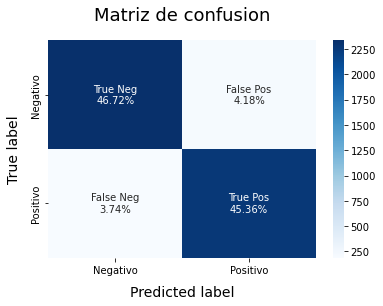

In [21]:
ConfusionMatrix(y_pred, y_test)